In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
"""
归一化 x = (x - u) / std  u:均值，std:方差
"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#x_train:[None, 28, 28] -> [None, 784]
x_train_scaler = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28) 
x_valid_scaler = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)   
x_test_scaler = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)   

In [4]:
# tf.keras.models.Sequential()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
# Tensorboard, earlystopping, Modelcheckpoint
logdir = "./dnn_bn_dropout_callbacks"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

history = model.fit(x_train_scaler, y_train, epochs=10,
                    validation_data=(x_valid_scaler, y_valid),
                    callbacks=callbacks)

Epoch 1/10
   1/1719 [..............................] - ETA: 0s - loss: 2.7807 - accuracy: 0.1875WARNING:tensorflow:From D:\software\anaconda\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1519 - accuracy: 0.6109 - val_loss: 0.7739 - val_accuracy: 0.7998
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6875 - accuracy: 0.7720 - val_loss: 0.6926 - val_accuracy: 0.8332
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5768 - accuracy: 0.8113 - val_loss: 0.6603 - val_accuracy: 0.8470
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5164 - accuracy: 0.8287 - val_loss: 0.6225 - val_accuracy: 0.8524
Epoch 5/10
1719/1719 [==============================] - 3s 2

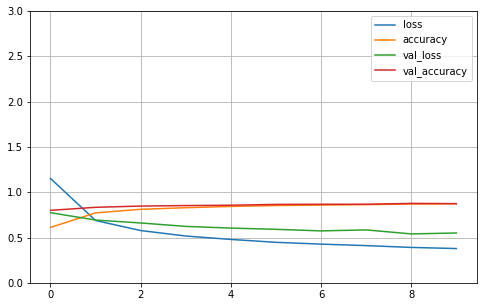

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()

plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaler, y_test)

313/313 [==============================] - 0s 806us/step - loss: 0.6290 - accuracy: 0.8595


[0.6289610862731934, 0.859499990940094]